In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt

d:\Program Files\anaconda3\envs\torch126\Lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
import sys
sys.path.append("D:\\0626_temp")

from flare_preprocessing import *
from utilities import *

In [3]:
opr = opr_data_preprocessing("D:/2024_S1/ML_SEP_2402/swpc_ftp/v2_ftp_flares_1997_2024.csv")
sci = sci_data_preprocessing("D:/2024_S1/ML_SEP_2402/Sci_matched_with_assigned_ar_20100101_20240721.csv", opr)

Shape of the operation data: (25364, 9)
Shape of the science-quality data: (30958, 31)


D:\0626_temp\utilities.py:64: RuntimeWarning: divide by zero encountered in log10
  return np.log10(intensity * 10 ** -8)


In [4]:
from New_SampleConstruction import *
from New_lstm2 import *

In [5]:
from pathlib import Path

def read_all_harp_csvs(root: str | Path, recursive: bool = False) -> pd.DataFrame:
    """
    Read all per-HARP CSVs under `root`, concatenate them in ascending HARP order,
    Assumes files are named like HARP_<harpnum>.csv.
    """

    root = Path(root)
    pattern = "**/HARP_*.csv" if recursive else "HARP_*.csv"

    # List files first, sorted by HARP number
    harp_files = []
    for f in root.glob(pattern):
        try:
            harpnum = int(f.stem.split("_")[1])
            harp_files.append((harpnum, f))
        except Exception:
            continue

    # sort by numeric harp number
    harp_files.sort(key=lambda x: x[0])

    frames = []

    for harpnum, f in harp_files:
        # read with T_REC parsed as datetime
        df = pd.read_csv(f, parse_dates=["T_REC"])
        print(f"Reading HARP {harpnum}")

        # Skip if the HARP lifetime is less than 120 rows (24h / 12min cadence)
        if len(df) < 120:
            print(f"  -> Skipping HARP {harpnum} (too short)")
            continue
        # fill the HARPNUM with the harpnum
        df['HARPNUM'] = harpnum
        frames.append(df)

    if not frames:
        print("No valid HARP CSVs found.")
        return pd.DataFrame()

    # Concatenate in correct order
    full_df = pd.concat(frames, ignore_index=True)
    print(f"Loaded {len(frames)} HARPs; total rows = {len(full_df)}")
    
    return full_df

In [6]:
nrt_sharps = read_all_harp_csvs(r"D:\\Input Data\\Operational Data\\HMI\SHARP_by_HARP")

Reading HARP 476
Reading HARP 487
Reading HARP 493
Reading HARP 495
Reading HARP 497
Reading HARP 498
Reading HARP 499
  -> Skipping HARP 499 (too short)
Reading HARP 500
  -> Skipping HARP 500 (too short)
Reading HARP 501
Reading HARP 502
Reading HARP 503
Reading HARP 504
Reading HARP 505
Reading HARP 506
  -> Skipping HARP 506 (too short)
Reading HARP 508
Reading HARP 509
Reading HARP 510
Reading HARP 511
Reading HARP 512
Reading HARP 513
  -> Skipping HARP 513 (too short)
Reading HARP 514
  -> Skipping HARP 514 (too short)
Reading HARP 515
Reading HARP 516
Reading HARP 518
  -> Skipping HARP 518 (too short)
Reading HARP 520
Reading HARP 521
Reading HARP 523
Reading HARP 524
  -> Skipping HARP 524 (too short)
Reading HARP 526
Reading HARP 527
Reading HARP 529
Reading HARP 532
Reading HARP 533
  -> Skipping HARP 533 (too short)
Reading HARP 534
Reading HARP 537
Reading HARP 547
  -> Skipping HARP 547 (too short)
Reading HARP 550
Reading HARP 552
  -> Skipping HARP 552 (too short)
Read

C:\Users\huke0\AppData\Local\Temp\ipykernel_11128\2427577827.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f, parse_dates=["T_REC"])


Reading HARP 11174
Reading HARP 11197
Reading HARP 11199
Reading HARP 11200
Reading HARP 11203
Reading HARP 11207
  -> Skipping HARP 11207 (too short)
Reading HARP 11209
Reading HARP 11210
Reading HARP 11211
  -> Skipping HARP 11211 (too short)
Reading HARP 11212
  -> Skipping HARP 11212 (too short)
Reading HARP 11215
Reading HARP 11217
Reading HARP 11218
Reading HARP 11219
Reading HARP 11220
  -> Skipping HARP 11220 (too short)
Reading HARP 11221
Reading HARP 11222
Reading HARP 11223
  -> Skipping HARP 11223 (too short)
Reading HARP 11224
  -> Skipping HARP 11224 (too short)
Reading HARP 11225
Reading HARP 11226
  -> Skipping HARP 11226 (too short)
Reading HARP 11227
  -> Skipping HARP 11227 (too short)
Reading HARP 11229
  -> Skipping HARP 11229 (too short)
Reading HARP 11231
  -> Skipping HARP 11231 (too short)
Reading HARP 11232
Reading HARP 11233
  -> Skipping HARP 11233 (too short)
Reading HARP 11234
  -> Skipping HARP 11234 (too short)
Reading HARP 11235
  -> Skipping HARP 11235

In [7]:
# delete rows with key columns any NaN values
key_columns = [
    'USFLUX','MEANGAM','MEANGBT','MEANGBZ','MEANGBH','MEANJZD',
    'TOTUSJZ','MEANALP','MEANJZH','TOTUSJH','ABSNJZH','SAVNCPP',
    'MEANPOT','TOTPOT','MEANSHR','SHRGT45','SIZE','SIZE_ACR',
    'NACR','NPIX'
]
nrt_sharps = nrt_sharps.dropna(subset=key_columns)

In [8]:
nrt_sharps.shape

(1662183, 28)

In [9]:
sci_obj_24 = New_SampleConstruction()
sci_obj_24.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=24)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [10]:
sci_obj_12 = New_SampleConstruction()
sci_obj_12.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=12)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [11]:
sci_obj_6 = New_SampleConstruction()
sci_obj_6.samples_from_harp(sci, nrt_sharps, lead_window=0, forecasting_window=6)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [12]:
opr_obj_24 = New_SampleConstruction()
opr_obj_24.samples_from_harp(opr, nrt_sharps, lead_window=0, forecasting_window=24)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [13]:
opr_obj_12 = New_SampleConstruction()
opr_obj_12.samples_from_harp(opr, nrt_sharps, lead_window=0, forecasting_window=12)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [14]:
opr_obj_6 = New_SampleConstruction()
opr_obj_6.samples_from_harp(opr, nrt_sharps, lead_window=0, forecasting_window=6)

Processing HARPNUM: 476
Processing HARPNUM: 487
Processing HARPNUM: 493
Processing HARPNUM: 495
Processing HARPNUM: 497
Processing HARPNUM: 498
Processing HARPNUM: 501
Processing HARPNUM: 502
Processing HARPNUM: 503
Processing HARPNUM: 504
Processing HARPNUM: 505
Processing HARPNUM: 508
Processing HARPNUM: 509
Processing HARPNUM: 510
Processing HARPNUM: 511
Processing HARPNUM: 512
Processing HARPNUM: 515
Processing HARPNUM: 516
Processing HARPNUM: 520
Processing HARPNUM: 521
Processing HARPNUM: 523
Processing HARPNUM: 527
Processing HARPNUM: 529
Processing HARPNUM: 532
Processing HARPNUM: 534
Processing HARPNUM: 537
Processing HARPNUM: 550
Processing HARPNUM: 553
Processing HARPNUM: 554
Processing HARPNUM: 555
Processing HARPNUM: 556
Processing HARPNUM: 559
Processing HARPNUM: 561
Processing HARPNUM: 562
Processing HARPNUM: 564
Processing HARPNUM: 565
Processing HARPNUM: 566
Processing HARPNUM: 567
Processing HARPNUM: 569
Processing HARPNUM: 570
Processing HARPNUM: 573
Processing HARPN

In [15]:
def GenMetrics_lstm(model_name, sample_obj, time1, time2, model_dir, threshold=0.5):
    #!!!!Note, the threshold is not saved
    te_pos_inputs,te_neg_inputs = get_samples(sample_obj.inputs_profile, sample_obj.labels, "Mplus_test",  time1, time2)
    #print(f"Positive: {te_pos_inputs.shape[0]}, Negative: {te_neg_inputs.shape[0]}")
    pos_rate = te_pos_inputs.shape[0]/(te_pos_inputs.shape[0]+te_neg_inputs.shape[0])
    te_inputs, te_targets = combine(te_pos_inputs, te_neg_inputs)
    te_inputs = normalize2(te_inputs, te_inputs.copy())
    inputs_tensor = torch.from_numpy(te_inputs).float().to(DEVICE)
    pods = []; fars = []; tsss = []; hsss = []; f1s = []; accs = []

    for i in range(30):
        path = os.path.join(model_dir, model_name+f"{i}.pth")
        model = lstm(te_inputs.shape[2]).to(DEVICE)
        state_dict = torch.load(path, map_location=DEVICE, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        with torch.no_grad():
            out = model(inputs_tensor)
            out = torch.sigmoid(out)
        y_pred_i = out.cpu().numpy().squeeze()
        y_pred_i = (y_pred_i > threshold).astype(int)
        tsss.append(TSS(y_pred_i, te_targets))
        pods.append(POD(y_pred_i, te_targets))
        fars.append(FAR(y_pred_i, te_targets))
        hsss.append(HSS(y_pred_i, te_targets))
        f1s.append(F1(y_pred_i, te_targets))
        accs.append(ACC(y_pred_i, te_targets))
    pods = np.array(pods); fars = np.array(fars); tsss = np.array(tsss); hsss = np.array(hsss); f1s = np.array(f1s); accs = np.array(accs)
    print(f"TSS: {np.array(tsss).mean():.2f}[{np.array(tsss).min():.2f},{np.array(tsss).max():.2f}]")
    print(f"HSS: {np.array(hsss).mean():.2f}[{np.array(hsss).min():.2f},{np.array(hsss).max():.2f}]")
    print(f"POD: {np.array(pods).mean():.2f}[{np.array(pods).min():.2f},{np.array(pods).max():.2f}]")
    print(f"F1: {np.array(f1s).mean():.2f}[{np.array(f1s).min():.2f},{np.array(f1s).max():.2f}]")
    print(f"FAR: {np.array(fars).mean():.2f}[{np.array(fars).min():.2f},{np.array(fars).max():.2f}]")
    print(f"ACC: {np.array(accs).mean():.2f}[{np.array(accs).min():.2f},{np.array(accs).max():.2f}]")
    return tsss, hsss, pods, f1s, fars, accs, pos_rate

import os
import joblib  

def GenMetrics_logreg(model_name, sample_obj, time1, time2, model_dir,
                      threshold=0.5):

    # --- get test samples ---
    te_pos_inputs, te_neg_inputs = get_samples(
        sample_obj.inputs_profile, sample_obj.labels, "Mplus_test", time1, time2
    )

    pos_rate = te_pos_inputs.shape[0] / (te_pos_inputs.shape[0] + te_neg_inputs.shape[0])

    te_inputs, te_targets = combine(te_pos_inputs, te_neg_inputs)
    te_inputs = np.array(te_inputs)

    X_test = np.array([x.flatten() for x in te_inputs])

    pods = []; fars = []; tsss = []; hsss = []; f1s = []; accs = []

    for i in range(30):
        path = os.path.join(model_dir, f"{model_name}{i}.pth")
        model = joblib.load(path)   # Pipeline: scale + PCA + logreg

        # predict probabilities for positive class
        y_prob_i = model.predict_proba(X_test)[:, 1]
        y_pred_i = (y_prob_i > threshold).astype(int)

        tsss.append(TSS(y_pred_i, te_targets))
        pods.append(POD(y_pred_i, te_targets))
        fars.append(FAR(y_pred_i, te_targets))
        hsss.append(HSS(y_pred_i, te_targets))
        f1s.append(F1(y_pred_i, te_targets))
        accs.append(ACC(y_pred_i, te_targets))

    tsss = np.array(tsss); hsss = np.array(hsss)
    pods = np.array(pods); fars = np.array(fars)
    f1s  = np.array(f1s);  accs = np.array(accs)

    print(f"TSS: {tsss.mean():.2f}[{tsss.min():.2f},{tsss.max():.2f}]")
    print(f"HSS: {hsss.mean():.2f}[{hsss.min():.2f},{hsss.max():.2f}]")
    print(f"POD: {pods.mean():.2f}[{pods.min():.2f},{pods.max():.2f}]")
    print(f"F1 : {f1s.mean():.2f}[{f1s.min():.2f},{f1s.max():.2f}]")
    print(f"FAR: {fars.mean():.2f}[{fars.min():.2f},{fars.max():.2f}]")
    print(f"ACC: {accs.mean():.2f}[{accs.min():.2f},{accs.max():.2f}]")

    return tsss, hsss, pods, f1s, fars, accs, pos_rate

In [16]:
import matplotlib.pyplot as plt
from pathlib import Path

def plot_metric_nrt(model_name1, obj1, dir1,
                     model_name2, obj2, dir2,
                     label1, label2,
                     figure_name,
                     lstm = True):
    time1_list = ('2020-01-01', '2022-01-01', '2020-01-01')
    time2_list = ('2022-01-01', '2025-01-01', '2025-01-01')
    period_labels = ['2020–2021', '2022–2024', '2020–2024']

    # boxplot data
    tss_box1 = []; hss_box1 = []; pod_box1 = []; f1_box1 = []; far_box1 = []; acc_box1 = []
    tss_box2 = []; hss_box2 = []; pod_box2 = []; f1_box2 = []; far_box2 = []; acc_box2 = []
    pos_rate_box1 = []; pos_rate_box2 = []

    for time1, time2 in zip(time1_list, time2_list):
        print(f"Time period: {time1} to {time2}")
        print("Model 1:")
        if lstm:
            tss1, hss1, pod1, f11, far1, acc1, pos_rate1 = GenMetrics_lstm(model_name1, obj1, time1, time2, dir1)
        else:
            tss1, hss1, pod1, f11, far1, acc1, pos_rate1 = GenMetrics_logreg(model_name1, obj1, time1, time2, dir1)
        tss_box1.append(tss1); hss_box1.append(hss1); pod_box1.append(pod1)
        f1_box1.append(f11); far_box1.append(far1); acc_box1.append(acc1)
        pos_rate_box1.append(pos_rate1)

        print("Model 2:")
        if lstm:
            tss2, hss2, pod2, f12, far2, acc2, pos_rate2 = GenMetrics_lstm(model_name2, obj2, time1, time2, dir2)
        else:
            tss2, hss2, pod2, f12, far2, acc2, pos_rate2 = GenMetrics_logreg(model_name2, obj2, time1, time2, dir2)
        tss_box2.append(tss2); hss_box2.append(hss2); pod_box2.append(pod2)
        f1_box2.append(f12); far_box2.append(far2); acc_box2.append(acc2)
        pos_rate_box2.append(pos_rate2)

    # ---- Plotting ----
    metrics = ['TSS', 'HSS', 'POD', 'F1', 'FAR', 'ACC']
    box1 = [tss_box1, hss_box1, pod_box1, f1_box1, far_box1, acc_box1]
    box2 = [tss_box2, hss_box2, pod_box2, f1_box2, far_box2, acc_box2]

    # ---- Save raw bootstrap values separately for Model 1 ----
    rows_model1 = []
    for i, metric in enumerate(metrics):
        for j, period in enumerate(time1_list):
            row = {
                "Metric": metric,
                "Period": f"{time1_list[j]} to {time2_list[j]}"
            }
            vals = np.array(box1[i][j])
            for k, v in enumerate(vals):
                row[f"Sample_{k+1}"] = v
            rows_model1.append(row)

    df_model1 = pd.DataFrame(rows_model1)
    path1 = Path(f"./results/raw_metrics_{label1}.csv")
    df_model1.to_csv(path1, index=False)

    # ---- Save raw bootstrap values separately for Model 2 ----
    rows_model2 = []
    for i, metric in enumerate(metrics):
        for j, period in enumerate(time1_list):
            row = {
                "Metric": metric,
                "Period": f"{time1_list[j]} to {time2_list[j]}"
            }
            vals = np.array(box2[i][j])
            for k, v in enumerate(vals):
                row[f"Sample_{k+1}"] = v
            rows_model2.append(row)

    df_model2 = pd.DataFrame(rows_model2)
    path2 = Path(f"./results/raw_metrics_{label2}.csv")
    df_model2.to_csv(path2, index=False)

    # positions: for 4 periods, each has 2 boxes
    # e.g. period 0 → x = 1,2 ; period 1 → x = 4,5 ; period 2 → x = 7,8 ; period 3 → x = 10,11
    n_periods = len(time1_list)
    base_gap = 3.0
    pos_model1 = [i * base_gap + 1 for i in range(n_periods)]
    pos_model2 = [i * base_gap + 2 for i in range(n_periods)]
    all_positions = []
    for p1, p2 in zip(pos_model1, pos_model2):
        all_positions.extend([p1, p2])
    # x locations for period centers (for xticks and pos rate lines)
    period_centers = [(p1 + p2) / 2.0 for p1, p2 in zip(pos_model1, pos_model2)]

    fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True)
    axes = axes.flatten()

    color1 = 'tab:blue'
    color2 = 'tab:orange'

    for i, metric in enumerate(metrics):
        ax = axes[i]

        # prepare boxplot data interleaving model1/model2 per period
        data = []
        for j in range(n_periods):
            data.append(box1[i][j])  # model 1 for this period
            data.append(box2[i][j])  # model 2 for this period

        bp = ax.boxplot(
            data,
            positions=all_positions,
            widths=0.7,
            patch_artist=True,
            manage_ticks=False,
            showmeans=True
        )

        # color boxes: even indices → model1, odd → model2
        for k, patch in enumerate(bp['boxes']):
            if k % 2 == 0:  # model1
                patch.set_facecolor(color1)
                patch.set_alpha(0.6)
            else:           # model2
                patch.set_facecolor(color2)
                patch.set_alpha(0.6)

        # Whisker & cap colors (optional)
        for k in range(len(bp['boxes'])):
            col = color1 if k % 2 == 0 else color2
            for wh in [bp['whiskers'][2*k], bp['whiskers'][2*k+1]]:
                wh.set_color(col)
            bp['caps'][2*k].set_color(col)
            bp['caps'][2*k+1].set_color(col)
            bp['medians'][k].set_color('black')

        ax.set_ylabel(metric)

        # Right axis for positive rate
        ax2 = ax.twinx()
        # make sure pos rate is scalar; if array, take mean
        def to_scalar(x):
            x = np.asarray(x)
            return float(x.mean()) if x.size > 1 else float(x)

        y1 = [to_scalar(v) for v in pos_rate_box1]
        y2 = [to_scalar(v) for v in pos_rate_box2]

        ax2.plot(period_centers, y1, linestyle='--', marker='o', color=color1, alpha=0.7)
        ax2.plot(period_centers, y2, linestyle='--', marker='s', color=color2, alpha=0.7)
        ax2.set_ylim(0, 1)
        if i % 2 != 0:
            ax2.set_ylabel('Positive sample ratio')

        # Only put legend on the first subplot to avoid clutter
        if i == 0:
            # use colors from boxplots for legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor=color1, edgecolor='k', label=label1, alpha=0.6),
                Patch(facecolor=color2, edgecolor='k', label=label2, alpha=0.6)
            ]
            ax2.legend(handles=legend_elements, loc='lower right', fontsize=10)

        # x-axis ticks only on bottom row
        ax.set_xticks(period_centers)
        if i >= 4:  # last row
            ax.set_xticklabels(period_labels, rotation=0, fontsize=10)
        else:
            ax.set_xticklabels([])

    fig.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()
    # save figure
    os.makedirs("./figures", exist_ok=True)
    fig.savefig(f"./figures/{figure_name}.pdf", dpi=300)


Time period: 2020-01-01 to 2022-01-01
Model 1:
TSS: 0.53[0.11,0.84]
HSS: 0.16[0.03,0.39]
POD: 0.89[0.49,1.00]
F1: 0.25[0.13,0.45]
FAR: 0.36[0.16,0.61]
ACC: 0.66[0.43,0.85]
Model 2:
TSS: 0.55[0.07,0.79]
HSS: 0.31[0.05,0.44]
POD: 0.78[0.25,1.00]
F1: 0.41[0.18,0.52]
FAR: 0.24[0.08,0.43]
ACC: 0.76[0.60,0.88]
Time period: 2022-01-01 to 2025-01-01
Model 1:
TSS: 0.48[0.21,0.72]
HSS: 0.34[0.16,0.57]
POD: 0.51[0.38,0.72]
F1: 0.67[0.55,0.84]
FAR: 0.03[0.00,0.34]
ACC: 0.63[0.54,0.79]
Model 2:
TSS: 0.36[0.20,0.58]
HSS: 0.23[0.13,0.42]
POD: 0.39[0.22,0.60]
F1: 0.55[0.37,0.75]
FAR: 0.03[0.00,0.19]
ACC: 0.54[0.42,0.70]
Time period: 2020-01-01 to 2025-01-01
Model 1:
TSS: 0.60[0.36,0.76]
HSS: 0.61[0.35,0.78]
POD: 0.70[0.54,0.79]
F1: 0.77[0.67,0.86]
FAR: 0.10[0.01,0.42]
ACC: 0.81[0.67,0.89]
Model 2:
TSS: 0.42[0.24,0.66]
HSS: 0.43[0.24,0.67]
POD: 0.52[0.33,0.73]
F1: 0.63[0.46,0.81]
FAR: 0.10[0.00,0.27]
ACC: 0.72[0.62,0.84]


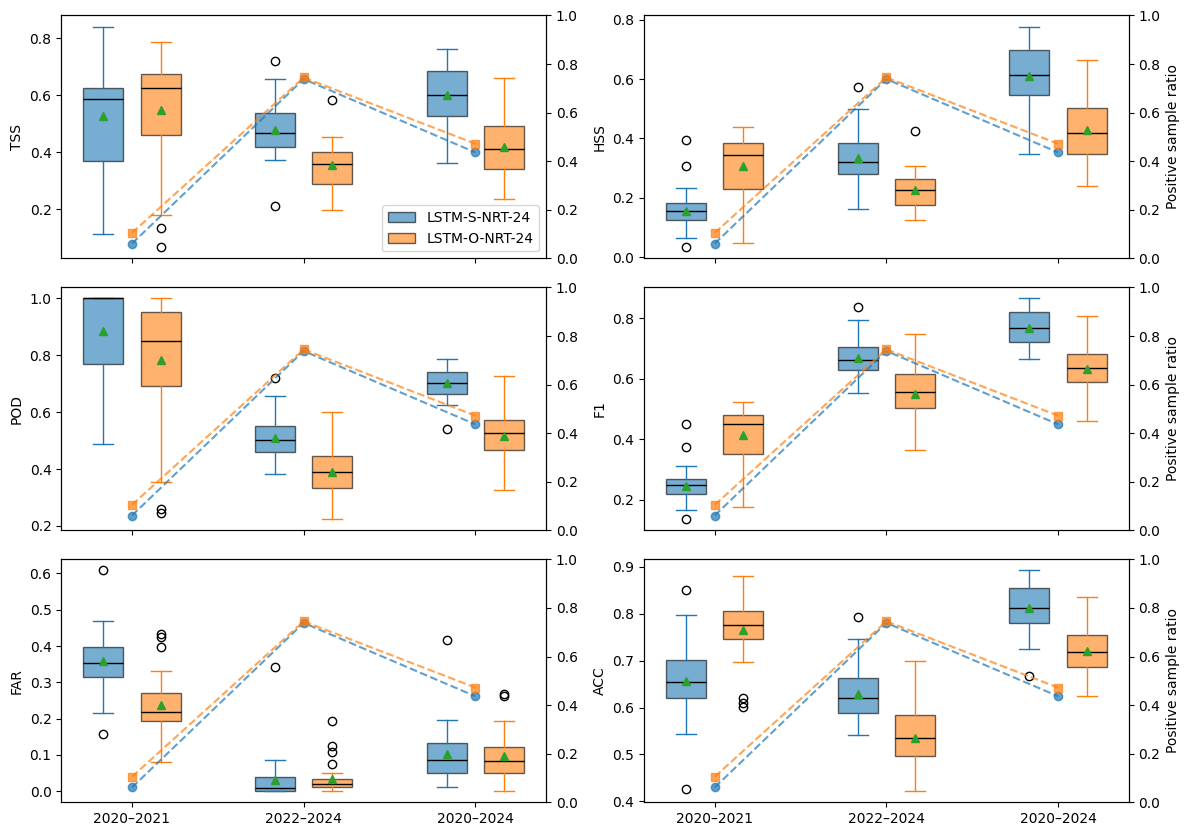

In [27]:
# LSTM 24, nrt sharps, sci vs opr
model_name1 = "NRT_lead0_Mplus_24_whole"
obj1 = sci_obj_24
dir1 = ".\\LSTM_models\\Sci_nrtSHARP"
model_name2 = "NRT_lead0_Mplus_24_whole"
obj2 = opr_obj_24
dir2 = ".\\LSTM_models\\Opr_nrtSHARP"
plot_metric_nrt(model_name1, obj1, dir1,
                     model_name2, obj2, dir2,
                     label1="LSTM-S-NRT-24", label2="LSTM-O-NRT-24",
                     figure_name="LSTM_24_nrtSHARPS_SCI_vs_OPR")

Time period: 2020-01-01 to 2022-01-01
Model 1:
TSS: 0.56[0.18,0.76]
HSS: 0.12[0.03,0.23]
POD: 0.95[0.71,1.00]
F1: 0.20[0.11,0.29]
FAR: 0.39[0.24,0.62]
ACC: 0.62[0.41,0.78]
Model 2:
TSS: 0.59[0.02,0.84]
HSS: 0.27[0.01,0.46]
POD: 0.84[0.28,1.00]
F1: 0.37[0.13,0.53]
FAR: 0.25[0.15,0.33]
ACC: 0.76[0.69,0.85]
Time period: 2022-01-01 to 2025-01-01
Model 1:
TSS: 0.49[0.30,0.60]
HSS: 0.33[0.18,0.44]
POD: 0.53[0.36,0.67]
F1: 0.68[0.52,0.79]
FAR: 0.04[0.00,0.13]
ACC: 0.63[0.50,0.72]
Model 2:
TSS: 0.34[0.02,0.51]
HSS: 0.23[0.01,0.37]
POD: 0.38[0.21,0.54]
F1: 0.54[0.32,0.70]
FAR: 0.05[0.00,0.19]
ACC: 0.54[0.37,0.66]
Time period: 2020-01-01 to 2025-01-01
Model 1:
TSS: 0.65[0.49,0.76]
HSS: 0.66[0.51,0.78]
POD: 0.75[0.55,0.85]
F1: 0.80[0.68,0.86]
FAR: 0.10[0.01,0.18]
ACC: 0.84[0.77,0.89]
Model 2:
TSS: 0.45[0.15,0.60]
HSS: 0.47[0.15,0.62]
POD: 0.54[0.35,0.70]
F1: 0.65[0.47,0.77]
FAR: 0.10[0.00,0.27]
ACC: 0.75[0.60,0.82]


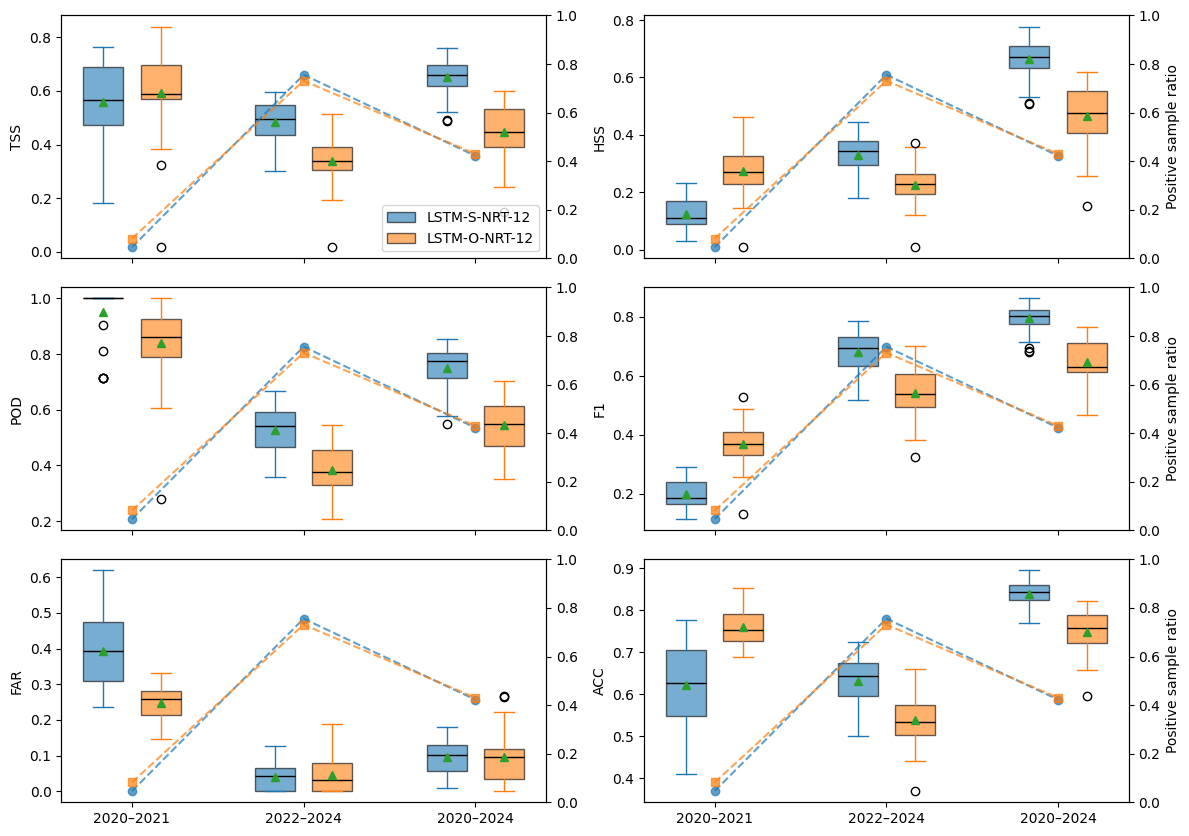

In [28]:
# LSTM 12, nrt sharps, sci vs opr
model_name1 = "NRT_lead0_Mplus_12_whole"
obj1 = sci_obj_12
dir1 = ".\\LSTM_models\\Sci_nrtSHARP"
model_name2 = "NRT_lead0_Mplus_12_whole"
obj2 = opr_obj_12
dir2 = ".\\LSTM_models\\Opr_nrtSHARP"
plot_metric_nrt(model_name1, obj1, dir1,
                     model_name2, obj2, dir2,
                     label1="LSTM-S-NRT-12", label2="LSTM-O-NRT-12",
                     figure_name="LSTM_12_nrtSHARPS_SCI_vs_OPR")

Time period: 2020-01-01 to 2022-01-01
Model 1:
TSS: 0.54[0.28,0.71]
HSS: 0.10[0.04,0.16]
POD: 0.92[0.75,1.00]
F1: 0.17[0.11,0.22]
FAR: 0.38[0.29,0.51]
ACC: 0.64[0.51,0.72]
Model 2:
TSS: 0.43[0.00,0.71]
HSS: 0.17[0.00,0.28]
POD: 0.66[0.12,1.00]
F1: 0.26[0.09,0.36]
FAR: 0.24[0.12,0.34]
ACC: 0.76[0.67,0.83]
Time period: 2022-01-01 to 2025-01-01
Model 1:
TSS: 0.56[0.42,0.67]
HSS: 0.39[0.28,0.49]
POD: 0.59[0.45,0.67]
F1: 0.74[0.62,0.81]
FAR: 0.03[0.00,0.15]
ACC: 0.68[0.58,0.75]
Model 2:
TSS: 0.37[0.16,0.59]
HSS: 0.26[0.10,0.44]
POD: 0.41[0.17,0.59]
F1: 0.57[0.29,0.74]
FAR: 0.03[0.00,0.13]
ACC: 0.56[0.40,0.70]
Time period: 2020-01-01 to 2025-01-01
Model 1:
TSS: 0.73[0.56,0.79]
HSS: 0.74[0.60,0.80]
POD: 0.80[0.60,0.87]
F1: 0.84[0.73,0.88]
FAR: 0.07[0.03,0.16]
ACC: 0.88[0.82,0.90]
Model 2:
TSS: 0.47[0.25,0.68]
HSS: 0.50[0.27,0.70]
POD: 0.56[0.33,0.74]
F1: 0.66[0.47,0.80]
FAR: 0.08[0.01,0.17]
ACC: 0.78[0.68,0.86]


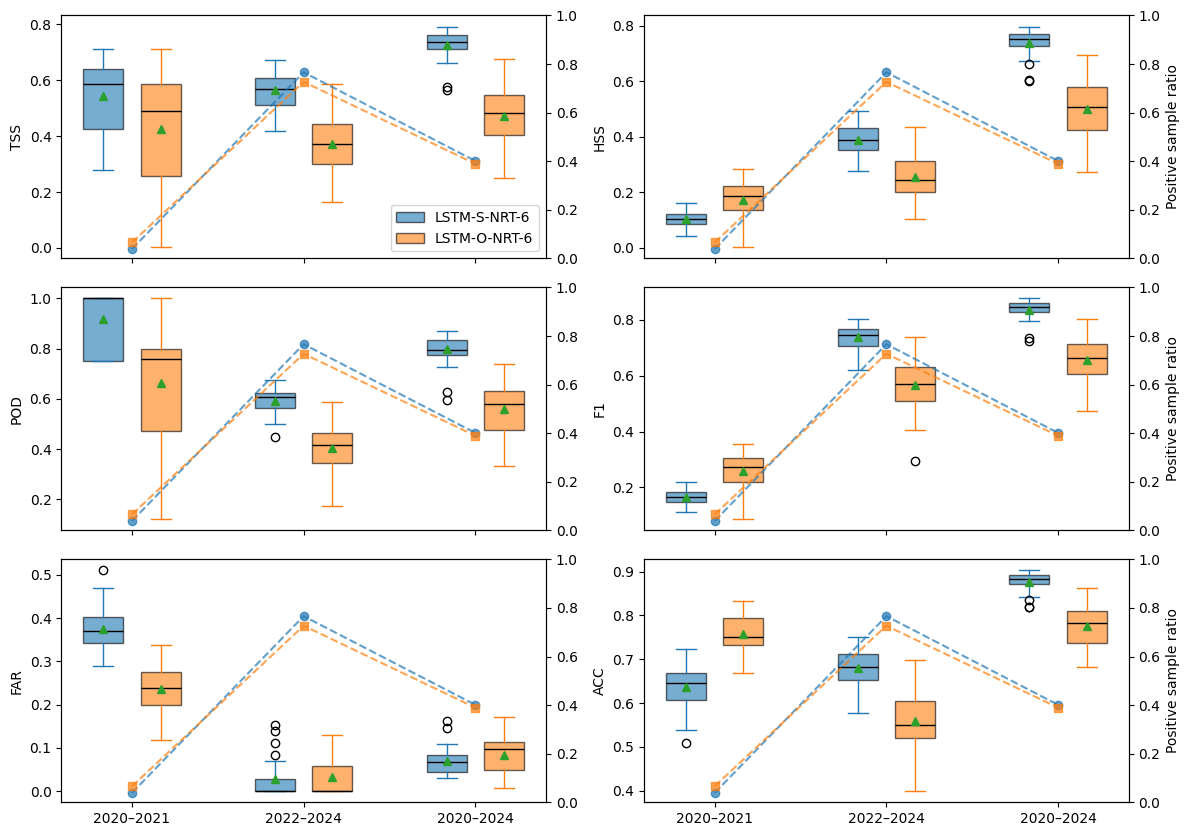

In [29]:
# LSTM 6, nrt sharps, sci vs opr
model_name1 = "NRT_lead0_Mplus_6_whole"
obj1 = sci_obj_6
dir1 = ".\\LSTM_models\\Sci_nrtSHARP"
model_name2 = "NRT_lead0_Mplus_6_whole"
obj2 = opr_obj_6
dir2 = ".\\LSTM_models\\Opr_nrtSHARP"
plot_metric_nrt(model_name1, obj1, dir1,
                     model_name2, obj2, dir2,
                     label1="LSTM-S-NRT-6", label2="LSTM-O-NRT-6",
                     figure_name="LSTM_6_nrtSHARPS_SCI_vs_OPR")

In [17]:
import os
import joblib  

def GenMetrics_logreg(model_name, sample_obj, time1, time2, model_dir,
                      threshold=0.5):

    # --- get test samples ---
    te_pos_inputs, te_neg_inputs = get_samples(
        sample_obj.inputs_profile, sample_obj.labels, "Mplus_test", time1, time2
    )

    pos_rate = te_pos_inputs.shape[0] / (te_pos_inputs.shape[0] + te_neg_inputs.shape[0])

    te_inputs, te_targets = combine(te_pos_inputs, te_neg_inputs)
    te_inputs = np.array(te_inputs)

    X_test = np.array([x.flatten() for x in te_inputs])

    pods = []; fars = []; tsss = []; hsss = []; f1s = []; accs = []

    for i in range(30):
        path = os.path.join(model_dir, f"{model_name}{i}.pth")
        model = joblib.load(path)   # Pipeline: scale + PCA + logreg

        # predict probabilities for positive class
        y_prob_i = model.predict_proba(X_test)[:, 1]
        y_pred_i = (y_prob_i > threshold).astype(int)

        tsss.append(TSS(y_pred_i, te_targets))
        pods.append(POD(y_pred_i, te_targets))
        fars.append(FAR(y_pred_i, te_targets))
        hsss.append(HSS(y_pred_i, te_targets))
        f1s.append(F1(y_pred_i, te_targets))
        accs.append(ACC(y_pred_i, te_targets))

    tsss = np.array(tsss); hsss = np.array(hsss)
    pods = np.array(pods); fars = np.array(fars)
    f1s  = np.array(f1s);  accs = np.array(accs)

    print(f"TSS: {tsss.mean():.2f}[{tsss.min():.2f},{tsss.max():.2f}]")
    print(f"HSS: {hsss.mean():.2f}[{hsss.min():.2f},{hsss.max():.2f}]")
    print(f"POD: {pods.mean():.2f}[{pods.min():.2f},{pods.max():.2f}]")
    print(f"F1 : {f1s.mean():.2f}[{f1s.min():.2f},{f1s.max():.2f}]")
    print(f"FAR: {fars.mean():.2f}[{fars.min():.2f},{fars.max():.2f}]")
    print(f"ACC: {accs.mean():.2f}[{accs.min():.2f},{accs.max():.2f}]")

    return tsss, hsss, pods, f1s, fars, accs, pos_rate

Time period: 2020-01-01 to 2022-01-01
Model 1:
TSS: 0.60[-0.06,0.84]
HSS: 0.35[-0.06,0.44]
POD: 0.71[0.00,0.97]
F1 : 0.40[0.00,0.49]
FAR: 0.12[0.06,0.18]
ACC: 0.87[0.81,0.91]
Model 2:
TSS: 0.61[0.35,0.75]
HSS: 0.39[0.27,0.48]
POD: 0.78[0.48,0.96]
F1 : 0.48[0.37,0.56]
FAR: 0.17[0.11,0.28]
ACC: 0.82[0.74,0.87]
Time period: 2022-01-01 to 2025-01-01
Model 1:
TSS: 0.58[0.46,0.69]
HSS: 0.57[0.46,0.64]
POD: 0.88[0.86,0.89]
F1 : 0.89[0.86,0.90]
FAR: 0.30[0.17,0.40]
ACC: 0.83[0.79,0.86]
Model 2:
TSS: 0.54[0.44,0.64]
HSS: 0.54[0.46,0.60]
POD: 0.88[0.86,0.91]
F1 : 0.88[0.87,0.89]
FAR: 0.35[0.22,0.47]
ACC: 0.82[0.80,0.84]
Time period: 2020-01-01 to 2025-01-01
Model 1:
TSS: 0.70[0.61,0.75]
HSS: 0.70[0.60,0.75]
POD: 0.87[0.81,0.90]
F1 : 0.84[0.79,0.86]
FAR: 0.16[0.09,0.24]
ACC: 0.85[0.80,0.88]
Model 2:
TSS: 0.65[0.57,0.70]
HSS: 0.65[0.56,0.70]
POD: 0.87[0.84,0.90]
F1 : 0.82[0.79,0.84]
FAR: 0.22[0.15,0.33]
ACC: 0.82[0.78,0.85]


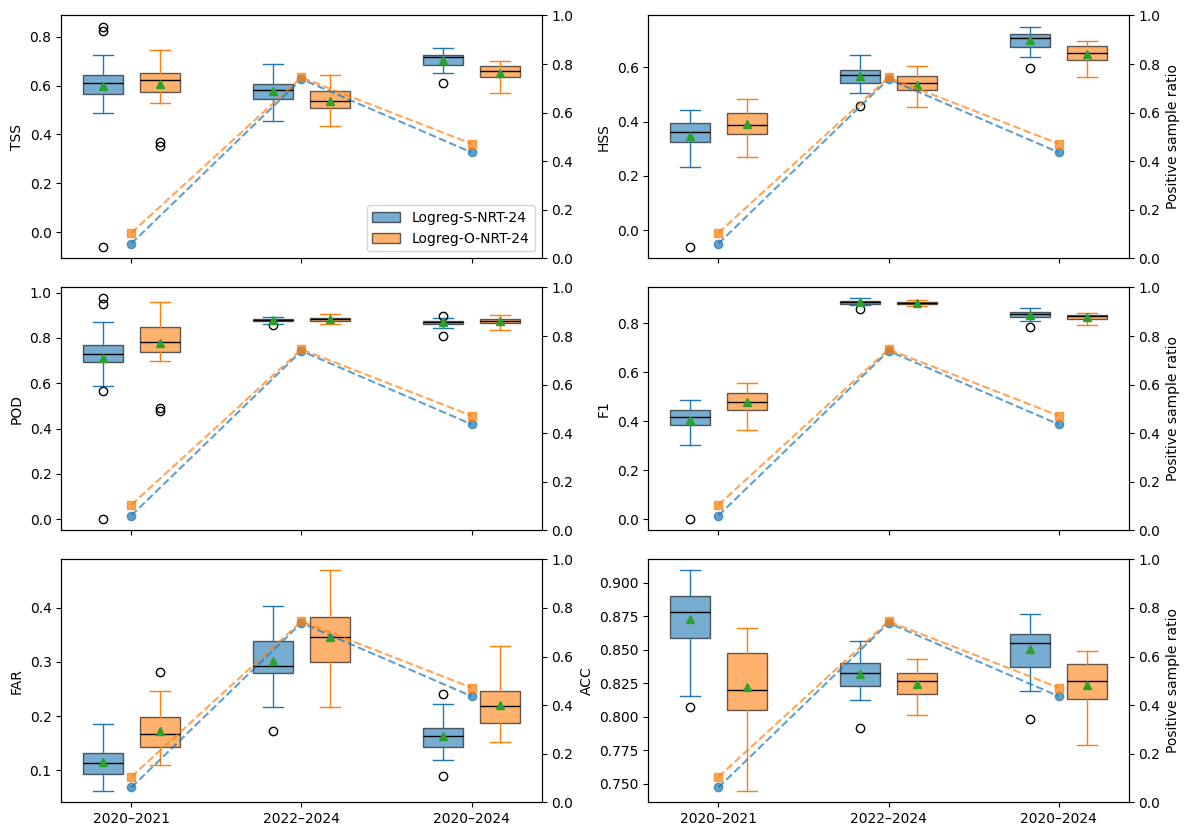

In [31]:
# logreg 24, nrt sharps, sci vs opr
model_name1 = "logistic_sci_nrtSHARP_24_"
obj1 = sci_obj_24
dir1 = ".\\Logreg_models\\Sci_nrtSHARP"
model_name2 = "logistic_opr_nrtSHARP_24_"
obj2 = opr_obj_24
dir2 = ".\\Logreg_models\\Opr_nrtSHARP"
plot_metric_nrt(model_name1, obj1, dir1,
                     model_name2, obj2, dir2,
                     label1="Logreg-S-NRT-24", label2="Logreg-O-NRT-24",
                     figure_name="Logreg_24_nrtSHARPS_SCI_vs_OPR",
                     lstm=False)

Time period: 2020-01-01 to 2022-01-01
Model 1:
TSS: 0.50[-0.07,0.81]
HSS: 0.22[-0.06,0.35]
POD: 0.63[0.00,0.95]
F1 : 0.28[0.00,0.40]
FAR: 0.13[0.06,0.22]
ACC: 0.86[0.79,0.91]
Model 2:
TSS: 0.49[0.24,0.68]
HSS: 0.26[0.12,0.37]
POD: 0.69[0.42,0.95]
F1 : 0.35[0.23,0.45]
FAR: 0.20[0.13,0.34]
ACC: 0.79[0.68,0.84]
Time period: 2022-01-01 to 2025-01-01
Model 1:
TSS: 0.62[0.49,0.74]
HSS: 0.60[0.49,0.70]
POD: 0.89[0.85,0.91]
F1 : 0.90[0.87,0.92]
FAR: 0.27[0.16,0.38]
ACC: 0.85[0.81,0.88]
Model 2:
TSS: 0.51[0.39,0.66]
HSS: 0.51[0.42,0.64]
POD: 0.88[0.85,0.90]
F1 : 0.87[0.85,0.90]
FAR: 0.37[0.23,0.51]
ACC: 0.81[0.78,0.85]
Time period: 2020-01-01 to 2025-01-01
Model 1:
TSS: 0.71[0.62,0.76]
HSS: 0.70[0.60,0.76]
POD: 0.87[0.82,0.90]
F1 : 0.83[0.79,0.86]
FAR: 0.16[0.08,0.26]
ACC: 0.85[0.80,0.88]
Model 2:
TSS: 0.62[0.52,0.70]
HSS: 0.60[0.49,0.70]
POD: 0.86[0.83,0.90]
F1 : 0.79[0.75,0.83]
FAR: 0.25[0.16,0.37]
ACC: 0.80[0.74,0.85]


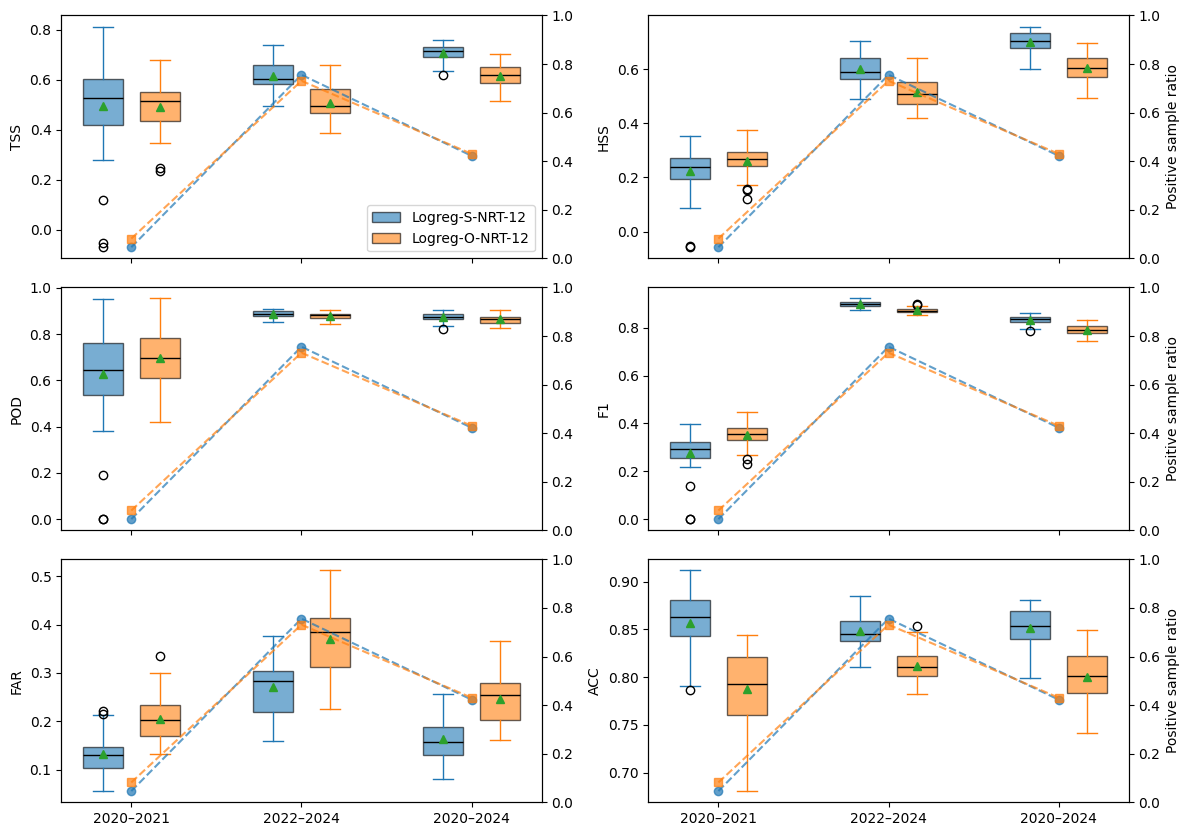

In [32]:
# logreg 12, nrt sharps, sci vs opr
model_name1 = "logistic_sci_nrtSHARP_12"
obj1 = sci_obj_12
dir1 = ".\\Logreg_models\\Sci_nrtSHARP"
model_name2 = "logistic_opr_nrtSHARP_12_"
obj2 = opr_obj_12
dir2 = ".\\Logreg_models\\Opr_nrtSHARP"
plot_metric_nrt(model_name1, obj1, dir1,
                     model_name2, obj2, dir2,
                     label1="Logreg-S-NRT-12", label2="Logreg-O-NRT-12",
                     figure_name="Logreg_12_nrtSHARPS_SCI_vs_OPR",
                     lstm=False)

Time period: 2020-01-01 to 2022-01-01
Model 1:
TSS: 0.41[-0.08,0.60]
HSS: 0.12[-0.05,0.22]
POD: 0.63[0.00,0.92]
F1 : 0.18[0.00,0.27]
FAR: 0.22[0.08,0.43]
ACC: 0.78[0.58,0.89]
Model 2:
TSS: 0.21[-0.09,0.51]
HSS: 0.09[-0.05,0.21]
POD: 0.44[0.08,0.80]
F1 : 0.18[0.05,0.29]
FAR: 0.23[0.15,0.31]
ACC: 0.75[0.69,0.80]
Time period: 2022-01-01 to 2025-01-01
Model 1:
TSS: 0.63[0.46,0.75]
HSS: 0.61[0.46,0.71]
POD: 0.89[0.86,0.92]
F1 : 0.90[0.87,0.93]
FAR: 0.26[0.11,0.42]
ACC: 0.85[0.80,0.89]
Model 2:
TSS: 0.49[0.38,0.62]
HSS: 0.48[0.39,0.58]
POD: 0.84[0.72,0.90]
F1 : 0.85[0.79,0.88]
FAR: 0.35[0.21,0.49]
ACC: 0.79[0.72,0.83]
Time period: 2020-01-01 to 2025-01-01
Model 1:
TSS: 0.65[0.46,0.78]
HSS: 0.63[0.43,0.77]
POD: 0.88[0.83,0.91]
F1 : 0.79[0.70,0.86]
FAR: 0.23[0.10,0.42]
ACC: 0.82[0.70,0.89]
Model 2:
TSS: 0.55[0.46,0.62]
HSS: 0.53[0.44,0.61]
POD: 0.80[0.71,0.87]
F1 : 0.73[0.68,0.77]
FAR: 0.26[0.17,0.35]
ACC: 0.77[0.72,0.81]


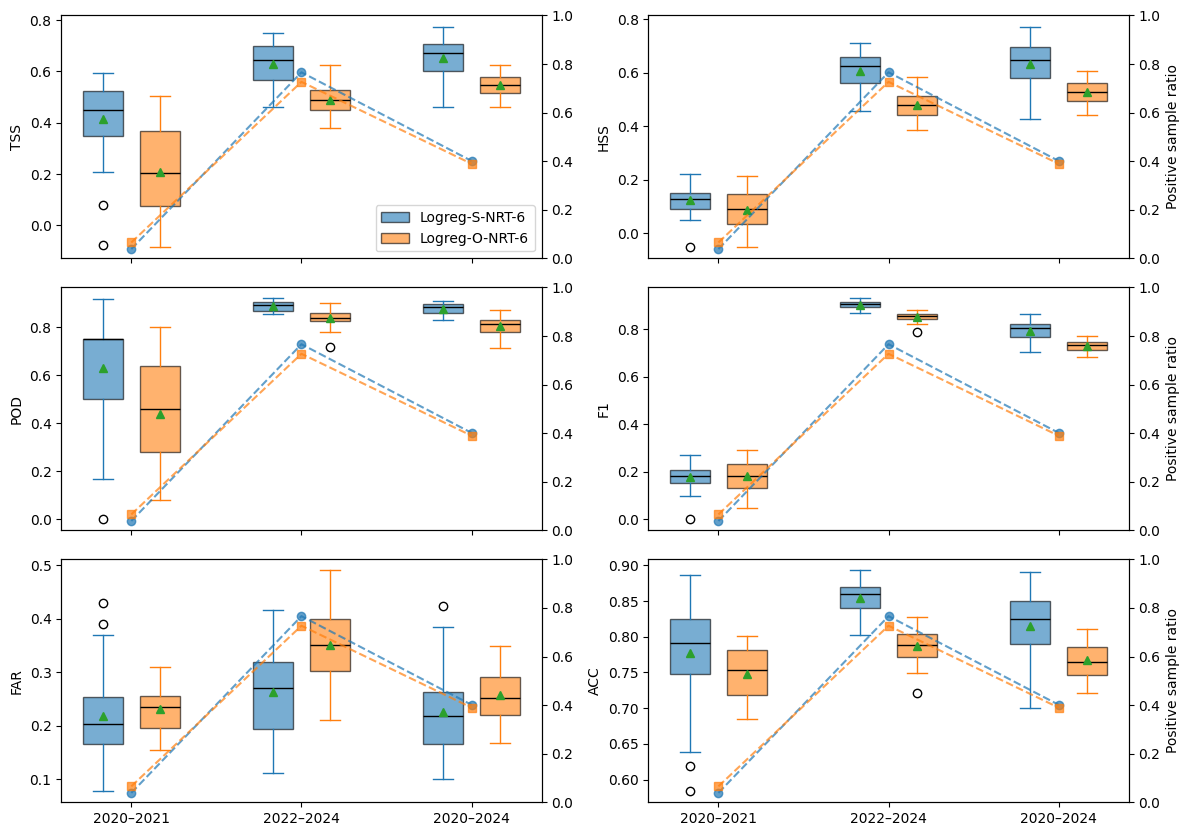

In [33]:
# logreg 6, nrt sharps, sci vs opr
model_name1 = "logistic_sci_nrtSHARP_6_"
obj1 = sci_obj_6
dir1 = ".\\Logreg_models\\Sci_nrtSHARP"
model_name2 = "logistic_opr_nrtSHARP_6_"
obj2 = opr_obj_6
dir2 = ".\\Logreg_models\\Opr_nrtSHARP"
plot_metric_nrt(model_name1, obj1, dir1,
                     model_name2, obj2, dir2,
                     label1="Logreg-S-NRT-6", label2="Logreg-O-NRT-6",
                     figure_name="Logreg_6_nrtSHARPS_SCI_vs_OPR",
                     lstm=False)

In [18]:
def load_metric_samples(csv_path, metric: str, period: str) -> np.ndarray:
    """
    Load all bootstrap samples for a given metric and period
    from a raw_metrics_*.csv file.
    """
    df = pd.read_csv(csv_path)

    mask = (df["Metric"] == metric) & (df["Period"] == period)
    row = df.loc[mask]
    if row.empty:
        raise ValueError(f"No row found in {csv_path} for Metric={metric}, Period={period}")

    row = row.iloc[0]
    sample_cols = [c for c in row.index if c.startswith("Sample_")]
    samples = row[sample_cols].to_numpy(dtype=float)
    return samples

In [38]:
from pathlib import Path
def plot_metric_gain_vs_baseline_multi(
    metric: str,
    period: str,
    forecast_hours_list: list[int],
    model_tags: list[str],
    baseline_tag: str = "Logreg-O-NRT",
    data_dir: str | Path = ".",
    legend: bool = True,
):

    data_dir = Path(data_dir)
    forecast_hours_list = list(forecast_hours_list)

    n_fw = len(forecast_hours_list)
    n_models = len(model_tags)

    # gains[fw_idx, model_idx], stds[fw_idx, model_idx]
    gains = np.zeros((n_fw, n_models), dtype=float)
    stds = np.zeros_like(gains)

    # baseline for this forecasting window
    baseline_file = data_dir / f"raw_metrics_{baseline_tag}-6.csv"
    baseline_samples = load_metric_samples(baseline_file, metric, period)
    baseline_mean = baseline_samples.mean()

    # ---- Load data & compute gains for each forecasting window ----
    for i, fh in enumerate(forecast_hours_list):

        for j, tag in enumerate(model_tags):
            try:
                csv_path = data_dir / f"raw_metrics_{tag}-{fh}.csv"
                samples = load_metric_samples(csv_path, metric, period)
            except:
                 csv_path = data_dir / f"NEW_raw_metrics_{tag}-{fh}.csv"
                 samples = load_metric_samples(csv_path, metric, period)
            mean_val = samples.mean()
            std_val = samples.std(ddof=1)

            gains[i, j] = mean_val - baseline_mean
            stds[i, j] = std_val

    # ---- Marker sizes: proportional to std over ALL (fw, model) pairs ----
    std_flat = stds.ravel()
    if np.all(std_flat == 0):
        sizes = np.full_like(stds, 150.0, dtype=float)
    else:
        std_norm = std_flat / std_flat.max()
        sizes_flat = 100 + 800 * std_norm  # tweak if needed
        sizes = sizes_flat.reshape(stds.shape)

    # ---- Plot ----
    x = np.arange(n_models)

    fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.axhline(0.0, color="k", linestyle="--", linewidth=1, label="Baseline (0 gain)")

    for i, fh in enumerate(forecast_hours_list):
        y = gains[i, :]
        s = sizes[i, :]

        # First plot a line to get a color from the cycle
        (line_handle,) = ax.plot(
            x,
            y,
            linestyle="-",
            linewidth=1.2,
            alpha=0.7,
            label=f"{fh}h forecast",
        )
        color = line_handle.get_color()

        # Then scatter with same color
        ax.scatter(
            x,
            y,
            s=s,
            marker="o",
            color=color,
            edgecolor="black",
            zorder=3,
            alpha=0.7
        )

        # (Optional) annotate each point with gain value
        for xi, gy in zip(x, y):
            if i%2 == 0:
                e = 0.2
            else:
                e = -0.2
            ax.text(
                xi+e,
                gy,
                f"{gy:+.2f}",
                ha="center",
                va="bottom",
                fontsize=7,
            )

    ax.set_xticks(x)
    ax.set_xticklabels(model_tags, rotation=25, ha="right")

    ax.set_ylabel(f"{metric} gain vs {baseline_tag}")
    fw_str = ", ".join(f"{fh}h" for fh in forecast_hours_list)
    ax.set_title(f"{metric} gain, {period}")
    ax.grid(axis="y", alpha=0.3)
    if legend:
        ax.legend()

    plt.tight_layout()
    os.makedirs("./figures", exist_ok=True)
    # encode all forecast hours in filename
    fw_part = "_".join(f"{fh}h" for fh in forecast_hours_list)
    fname = f"./figures/ALL_{metric}_gain_vs_baseline_{fw_part}_{period.replace(' ', '').replace('-', '')}.pdf"
    fig.savefig(fname, dpi=300)
    plt.show()

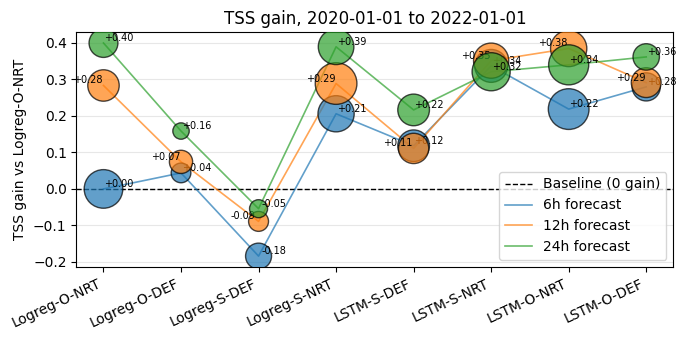

In [33]:
model_tags = [
    "Logreg-O-NRT",
    "Logreg-O-DEF",
    "Logreg-S-DEF",
    "Logreg-S-NRT",
    "LSTM-S-DEF",
    "LSTM-S-NRT",
    "LSTM-O-NRT",
    "LSTM-O-DEF",
]
plot_metric_gain_vs_baseline_multi(
    metric="TSS",
    period="2020-01-01 to 2022-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",
)

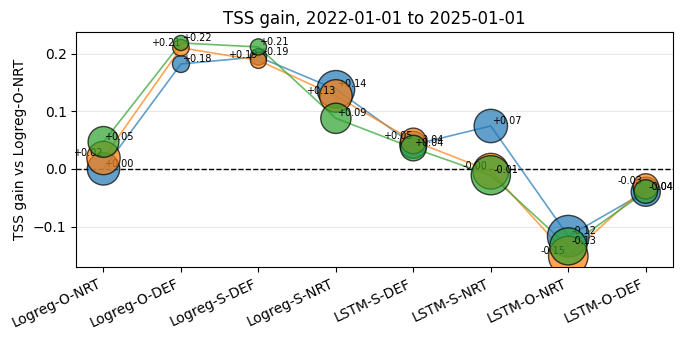

In [39]:
plot_metric_gain_vs_baseline_multi(
    metric="TSS",
    period="2022-01-01 to 2025-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",
    legend=False,
)

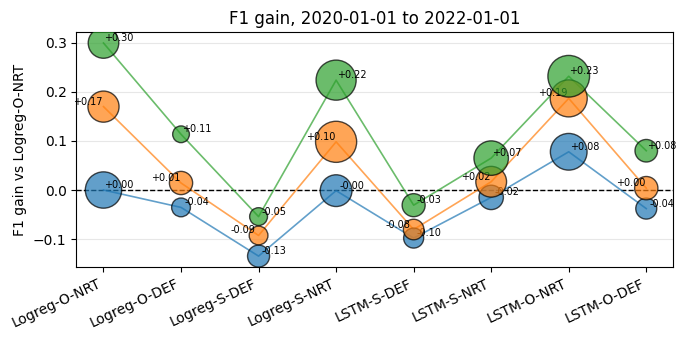

In [40]:
plot_metric_gain_vs_baseline_multi(
    metric="F1",
    period="2020-01-01 to 2022-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",
    legend=False,
)

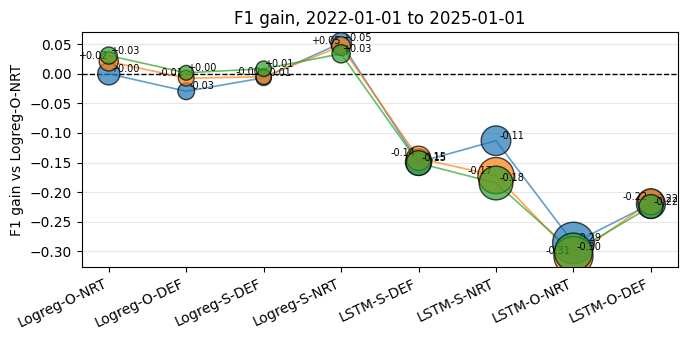

In [41]:
plot_metric_gain_vs_baseline_multi(
    metric="F1",
    period="2022-01-01 to 2025-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",
    legend=False,
)

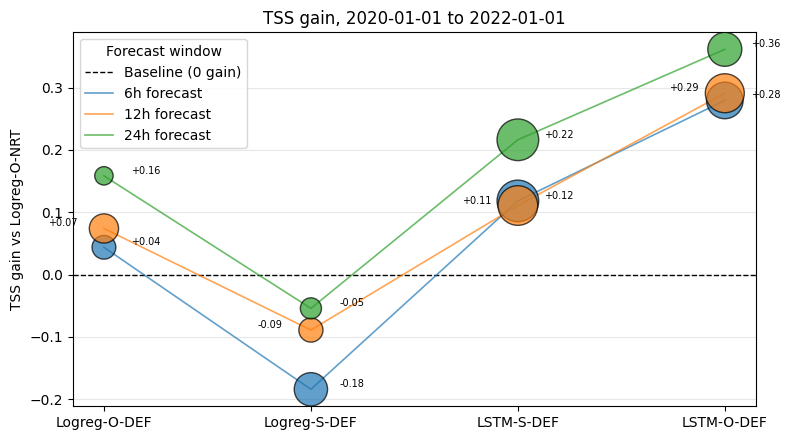

In [96]:
plot_metric_gain_vs_baseline_multi(
    metric="TSS",
    period="2020-01-01 to 2022-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",
)

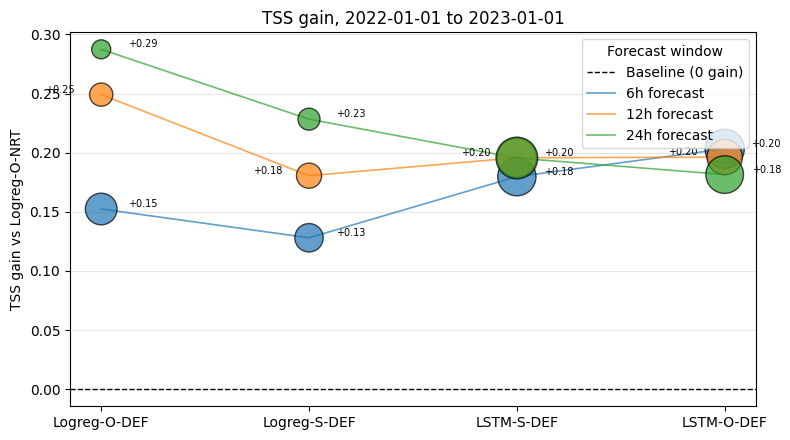

In [97]:
plot_metric_gain_vs_baseline_multi(
    metric="TSS",
    period="2022-01-01 to 2023-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",
)

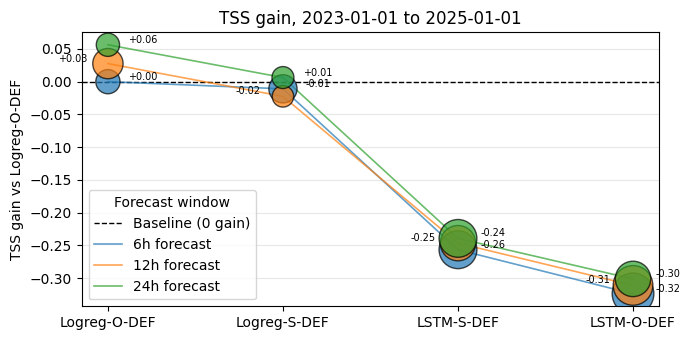

In [104]:
model_tags = [
    "Logreg-O-DEF",
    "Logreg-S-DEF",
    "LSTM-S-DEF",
    "LSTM-O-DEF",
]
plot_metric_gain_vs_baseline_multi(
    metric="TSS",
    period="2023-01-01 to 2025-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-DEF",
    data_dir=".\\results",
)

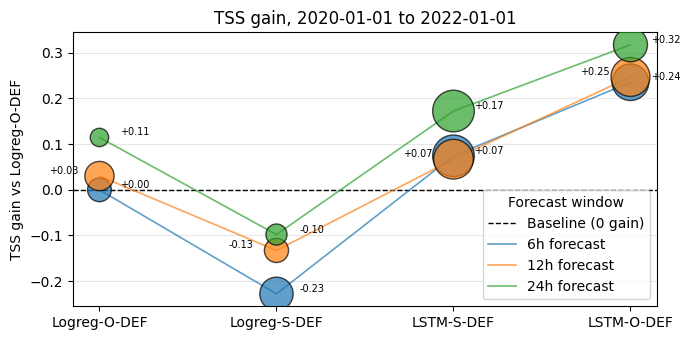

In [105]:
model_tags = [
    "Logreg-O-DEF",
    "Logreg-S-DEF",
    "LSTM-S-DEF",
    "LSTM-O-DEF",
]
plot_metric_gain_vs_baseline_multi(
    metric="TSS",
    period="2020-01-01 to 2022-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-DEF",
    data_dir=".\\results",
)

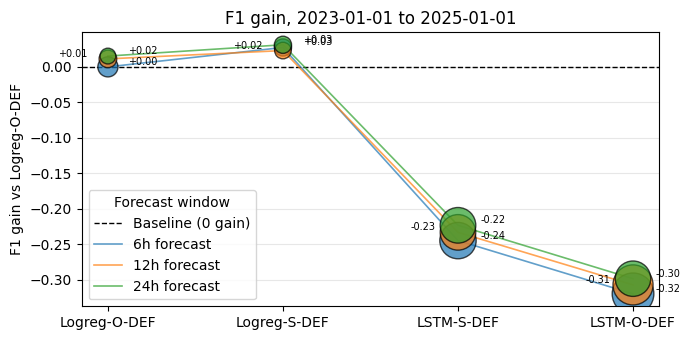

In [106]:
model_tags = [
    "Logreg-O-DEF",
    "Logreg-S-DEF",
    "LSTM-S-DEF",
    "LSTM-O-DEF",
]
plot_metric_gain_vs_baseline_multi(
    metric="F1",
    period="2023-01-01 to 2025-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-DEF",
    data_dir=".\\results",
)

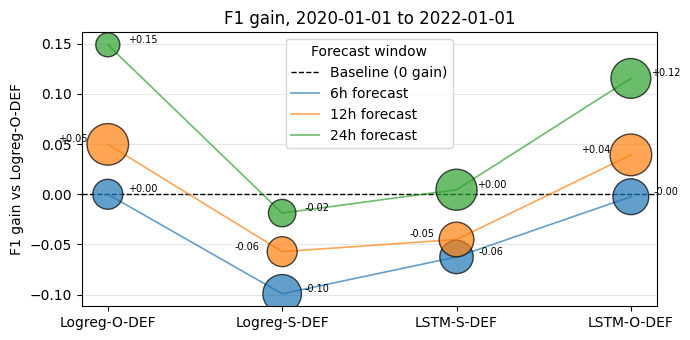

In [107]:
model_tags = [
    "Logreg-O-DEF",
    "Logreg-S-DEF",
    "LSTM-S-DEF",
    "LSTM-O-DEF",
]
plot_metric_gain_vs_baseline_multi(
    metric="F1",
    period="2020-01-01 to 2022-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-DEF",
    data_dir=".\\results",
)

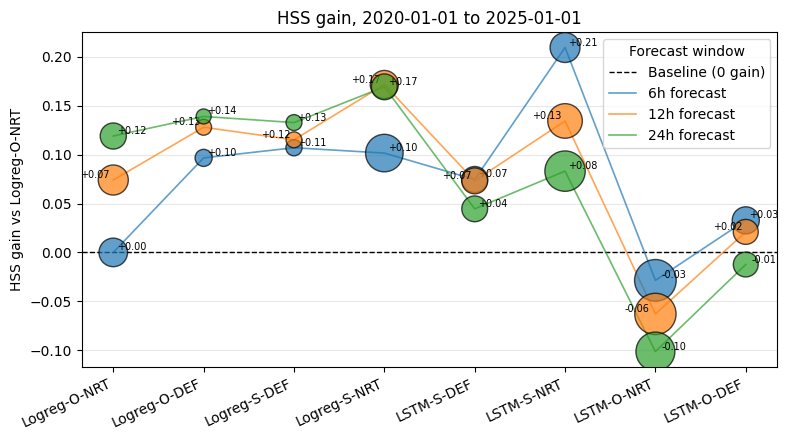

In [82]:
model_tags = [
    "Logreg-O-NRT",
    "Logreg-O-DEF",
    "Logreg-S-DEF",
    "Logreg-S-NRT",
    "LSTM-S-DEF",
    "LSTM-S-NRT",
    "LSTM-O-NRT",
    "LSTM-O-DEF",
]
plot_metric_gain_vs_baseline_multi(
    metric="HSS",
    period="2020-01-01 to 2025-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",
)


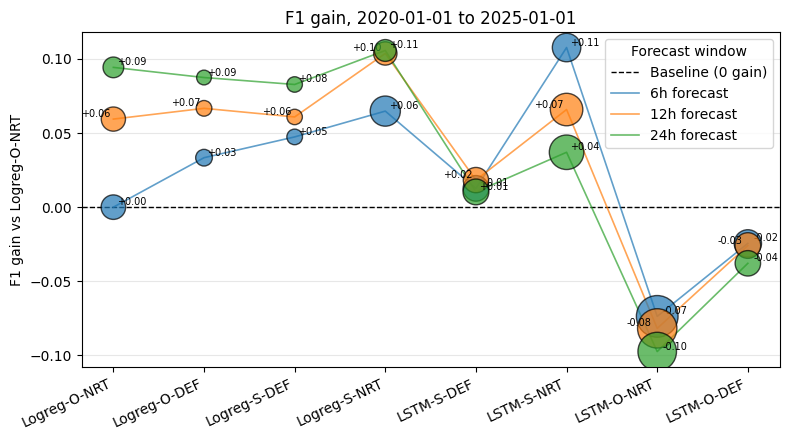

In [83]:
plot_metric_gain_vs_baseline_multi(
    metric="F1",
    period="2020-01-01 to 2025-01-01",
    forecast_hours_list=[6, 12, 24],
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",
)

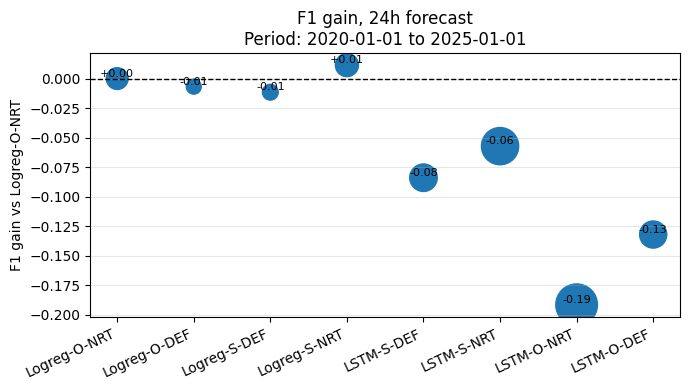

In [55]:
metric = "F1"
period = "2020-01-01 to 2025-01-01"
forecast_hours = 24

model_tags = [
    "Logreg-O-NRT",
    "Logreg-O-DEF",
    "Logreg-S-DEF",
    "Logreg-S-NRT",
    "LSTM-S-DEF",
    "LSTM-S-NRT",
    "LSTM-O-NRT",
    "LSTM-O-DEF",
]

gains, stds, labels = plot_metric_gain_vs_baseline(
    metric=metric,
    period=period,
    forecast_hours=forecast_hours,
    model_tags=model_tags,
    baseline_tag="Logreg-O-NRT",
    data_dir=".\\results",   
)
